In [1]:
import numpy as np
import pandas as pd

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
num = [1000, 2000, 5000]

dataframes = {
    target: pd.read_csv(f'../generated_molecules/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv('../generated_molecules/predicted_activity/Unconditional.csv')

for target in dataframes:
    df = dataframes[target]
    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds] == 'Invalid SMILES'])
    print(f"{target}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes[target] = df[df[col_preds] != 'Invalid SMILES'].copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes[target][col] = dataframes[target][col].astype(float)

    print(dataframes[target].shape)

_5HT2A: 3814
(26186, 3)
AChE: 5199
(24801, 3)
D2R: 3313
(26687, 3)
D3R: 3391
(26609, 3)
MAOB: 3195
(26805, 3)
Unconditional: 3515
(26485, 11)


In [8]:
aggs = ["SUM", "MEAN", "MAX"]
# aggs = ["MEAN", "MAX"]
# aggs = ["SUM"]

multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

for mts in dataframes_mt:
    df = dataframes_mt[mts]

    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds] == 'Invalid SMILES'])
    print(f"{mts}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes_mt[mts] = df[df[col_preds] != 'Invalid SMILES'].copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes_mt[mts][col] = dataframes_mt[mts][col].astype(float)
    
    print(dataframes_mt[mts].shape)

AChE_MAOB_SUM: 5009
(24991, 5)
D2R__5HT2A_SUM: 3976
(26024, 5)
D2R_D3R_SUM: 3631
(26369, 5)
AChE_MAOB_MEAN: 2387
(27613, 5)
D2R__5HT2A_MEAN: 2111
(27889, 5)
D2R_D3R_MEAN: 2239
(27761, 5)
AChE_MAOB_MAX: 2414
(27586, 5)
D2R__5HT2A_MAX: 2092
(27908, 5)
D2R_D3R_MAX: 2197
(27803, 5)


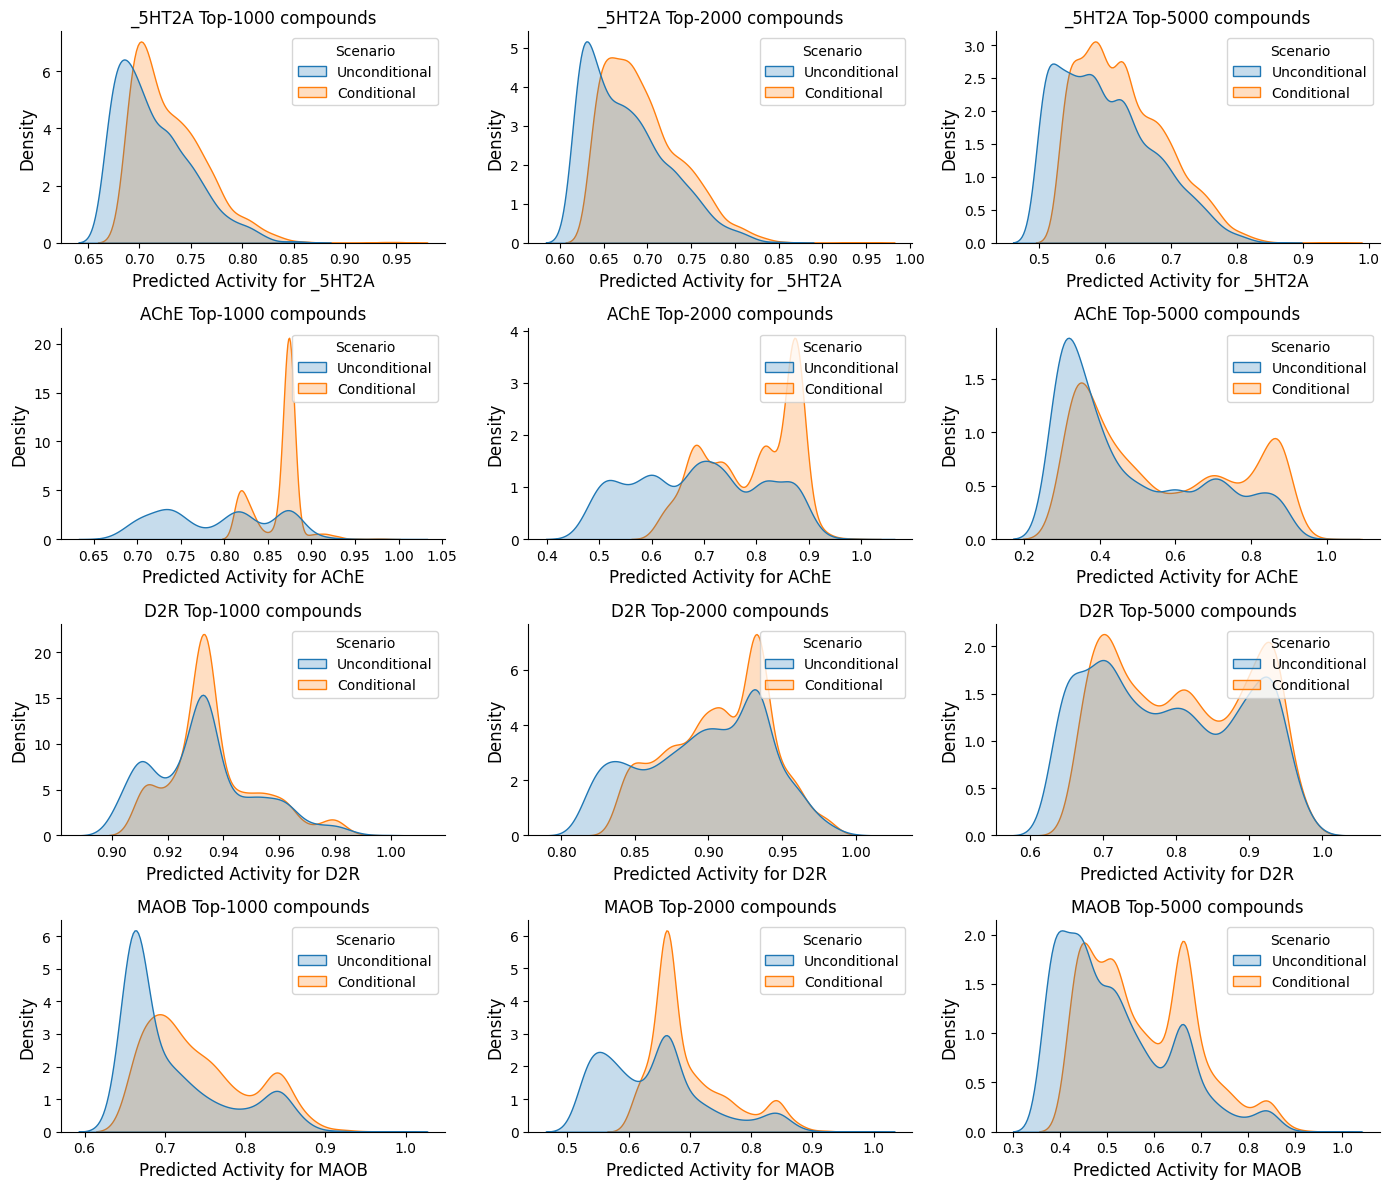

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ACT_TYPE = "Activity" 
# ACT_TYPE = "pIC50"
# ACT_TYPE = "pIC50"

pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(len(targets), len(num), figsize=(14, 12))

for i, name in enumerate(targets):
    for j, n in enumerate(num):
        activity_column = f"{name}_{ACT_TYPE}"
        unconditional = dataframes["Unconditional"][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Unconditional")

        conditional = dataframes[name][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Conditional")

        activities = pd.concat([unconditional, conditional]).reset_index()

        sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)
        # sns.histplot(data=activities, x=activity_column, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

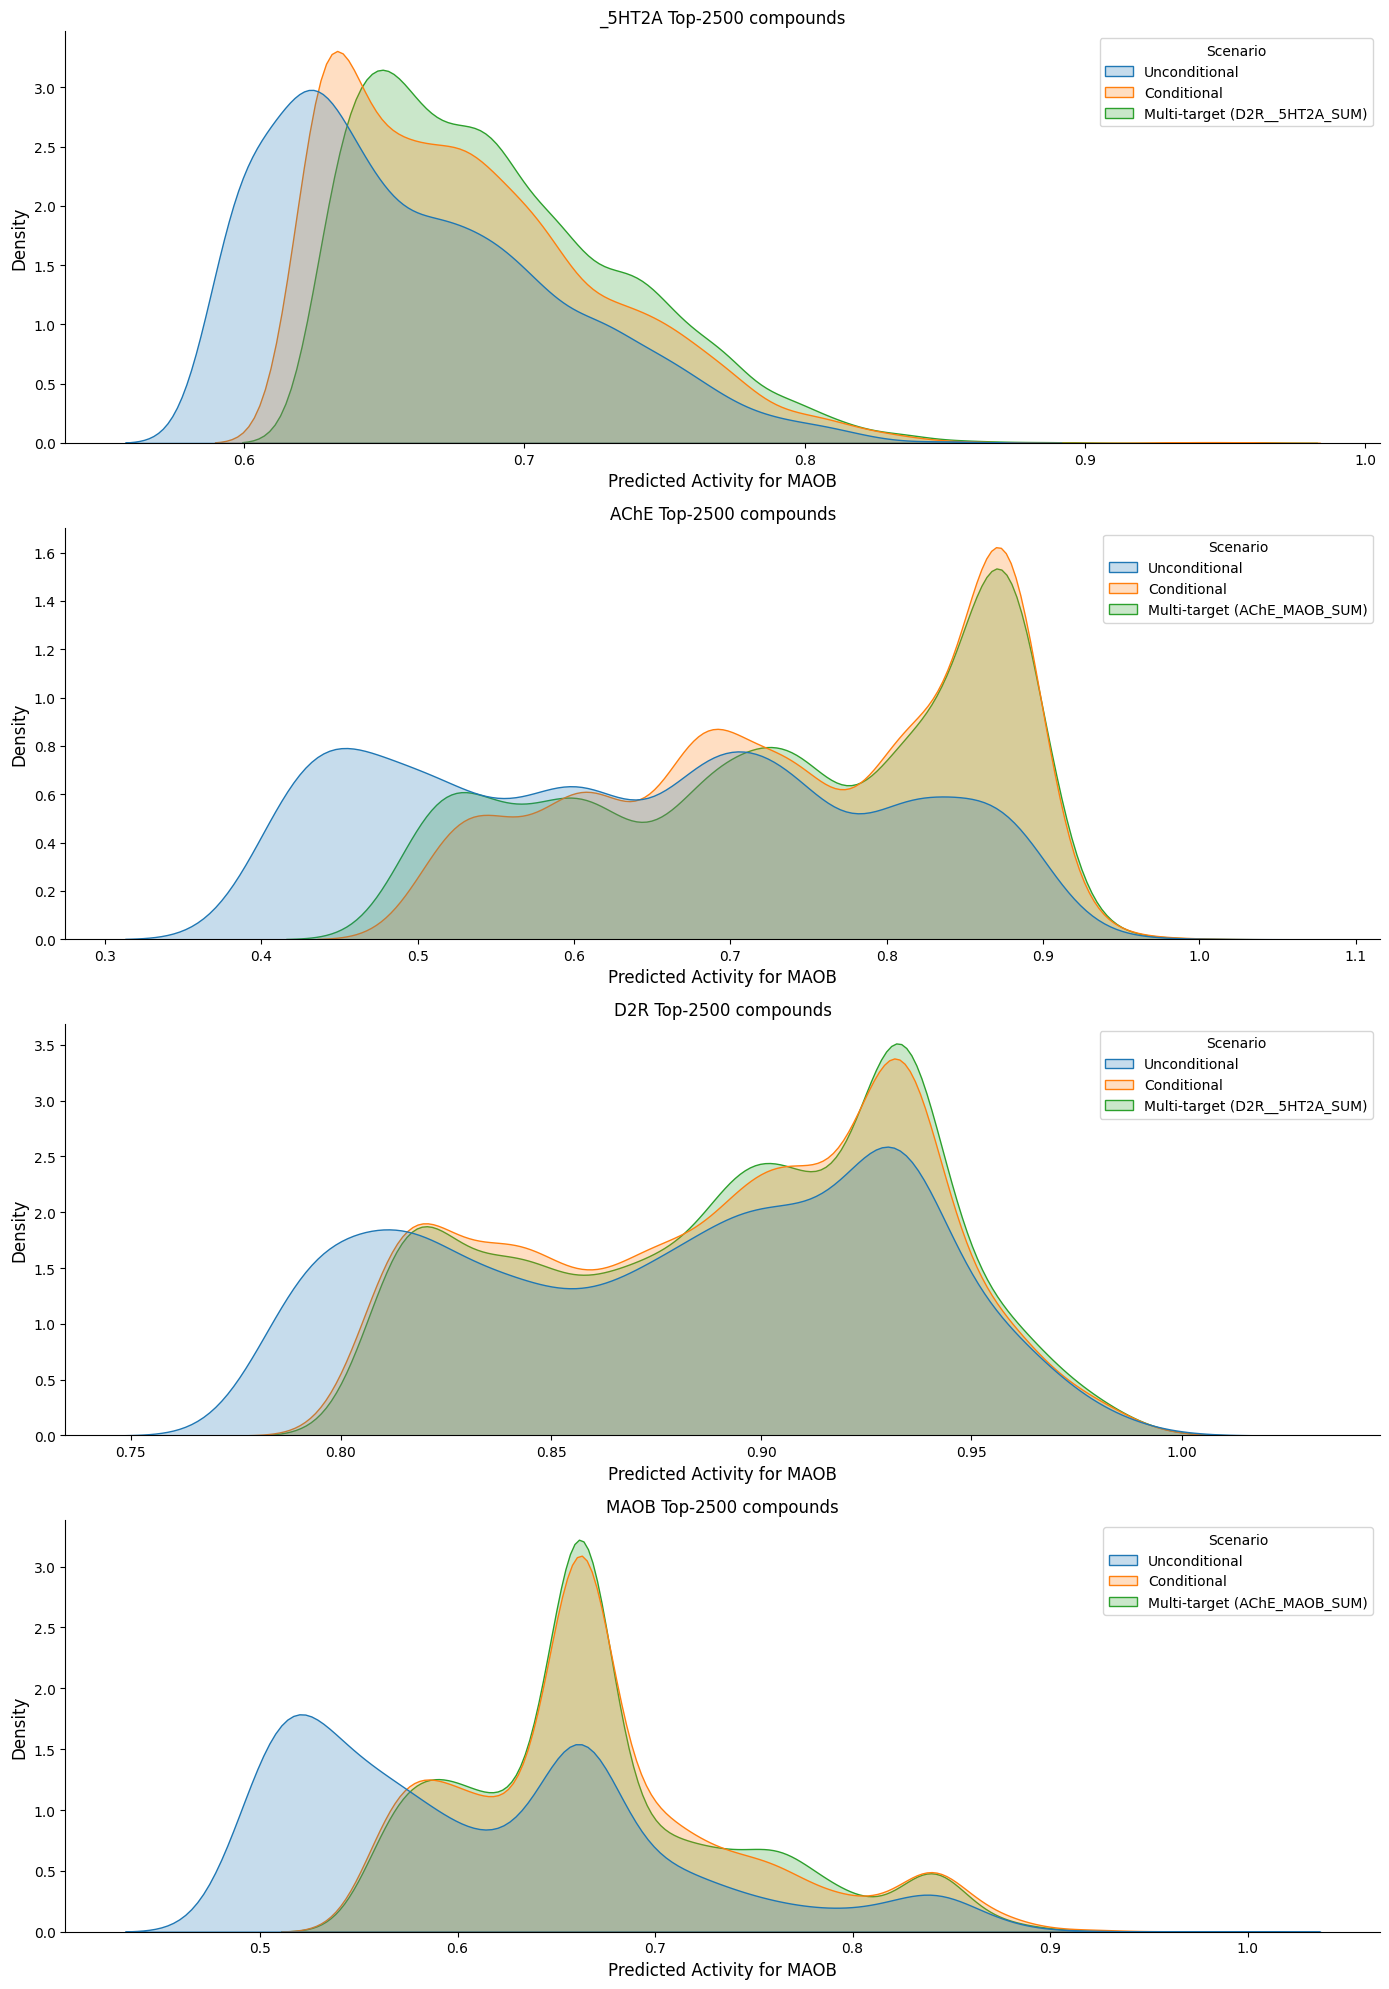

In [10]:
# Plot the multi-target distributions for the top 1000 compounds
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    # f"D2R_D3R_{agg}"
]

# targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), 1, figsize=(14, 20))
n = 2500

for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(target, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

plt.tight_layout()
plt.show()

In [12]:
multi_targets

['AChE_MAOB_SUM', 'D2R__5HT2A_SUM']

In [11]:
for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])

    # print(f"Target: {target}")
    display(pivot.style
                 .format("{:.2%}")
                 .set_caption(f"Top-{n} {target} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,mean,std
,_5HT2A_Activity,_5HT2A_Activity
Scenario,,
Conditional,68.18%,4.81%
Multi-target (D2R__5HT2A_SUM),69.08%,4.65%
Unconditional,66.10%,5.16%


,mean,std
,AChE_Activity,AChE_Activity
Scenario,,
Conditional,74.44%,11.86%
Multi-target (AChE_MAOB_SUM),73.59%,12.69%
Unconditional,63.85%,14.79%


,mean,std
,D2R_Activity,D2R_Activity
Scenario,,
Conditional,89.07%,4.63%
Multi-target (D2R__5HT2A_SUM),89.27%,4.60%
Unconditional,87.78%,5.40%


,mean,std
,MAOB_Activity,MAOB_Activity
Scenario,,
Conditional,67.37%,7.52%
Multi-target (AChE_MAOB_SUM),67.35%,7.35%
Unconditional,61.38%,9.43%


### Why does this approach seems to work for well for EGFR/S1PR1 target pair, but not for the pairs containing HTR1A?

In [ ]:
import sys
import torch
from collections import namedtuple

sys.path.append('../')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../train.smi'))
mol_list0_test = list(read_delimited_file('../test.smi'))

mol_list1, target_list = zip(*read_csv_file('../mol_target_dataloader/target.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=4)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../model_finetune_original.h5'))

In [ ]:
target_to_key = {
    "EGFR": torch.tensor([0]).to(device),
    "HTR1A": torch.tensor([1]).to(device),
    "S1PR1": torch.tensor([2]).to(device)
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["EGFR"].shape

In [ ]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

similarity

In [ ]:
# plot the similarity matrix
import seaborn as sns

similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [ ]:
egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
APQSSEFIGA"""

htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
RQ"""

s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
PQKDEGDNPETIMSSGNVNSSS"""

In [ ]:
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner

egfr_seq = Seq(egfr_sequence.replace('\n', ''))
htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

targets_seq = {
    "EGFR": egfr_seq,
    "HTR1A": htr1a_seq,
    "S1PR1": s1pr1_seq
}

egfr_seq

In [ ]:
aligner = PairwiseAligner()

for target1 in targets_seq:
    for target2 in targets_seq:
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        print(f"Alignment between {target1} and {target2}")
        # print(best_alignment)

        # Calculate sequence similarity as the fraction of identical residues
        similarity = best_alignment.score / len(targets_seq[target1])

        print(f"Similarity: {similarity:.2f}")

# plot the similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets_seq):
    for j, target2 in enumerate(targets_seq):
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets_seq.keys(), 
    yticklabels=targets_seq.keys()
)

plt.title('Target Protein Sequence Similarity')

plt.show()

In [ ]:
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

import lightgbm as lgb
from process_training_data import get_fp

# load qsar models for each target
targets = ["EGFR", "HTR1A", "S1PR1"]

model = dict()

for target in targets:
    model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# load active molecules dataset for each target
active_molecules = dict()

for target in targets:
    X = np.load('npy/{}_X.npy'.format(target))
    y = np.load('npy/{}_y.npy'.format(target))

    print(X.shape, y.shape)

    res = pd.DataFrame(X, columns=list(range(len(X[0]))))
    res['activity'] = y

    # res_active = res[res['activity'] >= 6.5]

    active_molecules[target] = res

# for each model, predict the activity of the active molecules datasets
predicted_activities = dict()

for target_model in targets:
    predicted_activities[target_model] = dict()

    for target_dataset in targets:
        X = active_molecules[target_dataset].drop(columns=['activity']).values
        y = active_molecules[target_dataset]['activity'].values

        predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# plot a scatter plot of the predicted activities for each target
# each row is a target model, each column is a target dataset
# the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
fig, axes = plt.subplots(3, 3, figsize=(14, 12))

for i, target_model in enumerate(targets):
    for j, target_dataset in enumerate(targets):
        axes[i, j].scatter(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity'], 
            # predicted_activities[target_dataset][target_dataset],
            alpha=0.3,
            color=pal[i]
        )

        axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
        axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
        axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

        # calculate the correlation coefficient
        correlation = np.corrcoef(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity']
        )[0, 1]

        axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i, j].transAxes)


plt.tight_layout()
plt.show()

In [ ]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../mol_target_dataloader/target.smi", sep="\t", names=["SMILES", "target"])

targets_ids = {
    "EGFR": 1,
    "HTR1A": 2,
    "S1PR1": 3
}    

for target in targets_ids:
    _id = targets_ids[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(500)

active_molecules_smiles

In [ ]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [ ]:
all_active_molecules = pd.DataFrame()

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

In [ ]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

In [ ]:
training_mols = pd.read_csv(
    "../mol_target_dataloader/target.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
)

targets = ["EGFR", "HTR1A", "S1PR1"]

for target in targets:
    transformers = pd.DataFrame({
        'SMILES': pd.read_csv('../generated_molecules/smiles/{}.smi'.format(target))["SMILES"],
        'pred_pXC50': np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(target))
    })

    smiles_top_3000 = transformers.sort_values(
        by=['pred_pXC50'],ascending=False
    ).head(3000)

    smiles_top_3000['target'] = f"{target} (generated)"
    generated_mols = smiles_top_3000[["SMILES", "target"]]

    training_mols = pd.concat([training_mols, generated_mols])

training_mols["target"].value_counts()

In [ ]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"EGFR_HTR1A_{agg}", "EGFR", "HTR1A"),
    (f"EGFR_S1PR1_{agg}", "EGFR", "S1PR1"),
    (f"HTR1A_S1PR1_{agg}", "HTR1A", "S1PR1")
]

for (mt, t1, t2) in multi_targets:
    transformers = pd.DataFrame({
        'SMILES': pd.read_csv(f'../generated_molecules/smiles/{mt}.smi')["SMILES"],
        'pred_pXC50_T1': np.load(f'../generated_molecules/npy/{mt}_Y_{t1}.npy'),
        'pred_pXC50_T2': np.load(f'../generated_molecules/npy/{mt}_Y_{t2}.npy')
    })

    transformers['pred_pXC50'] = transformers[['pred_pXC50_T1', 'pred_pXC50_T2']].mean(axis=1)

    smiles_top_3000 = transformers.sort_values(
        by=['pred_pXC50'],ascending=False
    ).head(3000)

    smiles_top_3000['target'] = f"{mt}"
    generated_mols = smiles_top_3000[["SMILES", "target"]]

    training_mols = pd.concat([training_mols, generated_mols])

In [ ]:
training_mols["target"].value_counts()

In [ ]:
import numpy as np
import tmap as tm
import pandas as pd
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from collections import Counter
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from IPython.display import IFrame

filter_types = [
    "EGFR",
    # "HTR1A",
    "S1PR1",
    "EGFR (generated)",
    # "HTR1A (generated)",
    "S1PR1 (generated)",
    # "EGFR_HTR1A_SUM",
    "EGFR_S1PR1_SUM",
    # "HTR1A_S1PR1_SUM"
]

colors = {
    "EGFR": "green",
    "EGFR (generated)": "darkgreen",
    # green + red
    "EGFR_HTR1A_SUM": "yellow",
    # green + blue
    "EGFR_S1PR1_SUM": "cyan",
    "HTR1A": "red",
    "HTR1A (generated)": "darkred",
    # red + blue
    "HTR1A_S1PR1_SUM": "magenta",
    "S1PR1": "blue",
    "S1PR1 (generated)": "darkblue",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols.query("target in @filter_types")

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(1024, 64)

    fps = []
    hac = []
    c_frac = []
    ring_atom_frac = []
    largest_ring_size = []

    for i, row in df.iterrows():
        if i != 0 and i % 1000 == 0:
            print(f"{i / len(df):0.2%} done")
        mol = AllChem.MolFromSmiles(row["SMILES"])
        atoms = mol.GetAtoms()
        size = mol.GetNumHeavyAtoms()
        n_c = 0
        n_ring_atoms = 0
        for atom in atoms:
            if atom.IsInRing():
                n_ring_atoms += 1
            if atom.GetSymbol().lower() == "c":
                n_c += 1

        c_frac.append(n_c / size)
        ring_atom_frac.append(n_ring_atoms / size)
        sssr = AllChem.GetSymmSSSR(mol)
        if len(sssr) > 0:
            largest_ring_size.append(max([len(s) for s in sssr]))
        else:
            largest_ring_size.append(0)
        hac.append(size)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    c_frak_ranked = ss.rankdata(np.array(c_frac) / max(c_frac)) / len(c_frac)

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    # tab_10 = plt.cm.get_cmap("tab10")
    # colors = [i for i in tab_10.colors]
    # colors[7] = (0.17, 0.24, 0.31)
    # tab_10.colors = tuple(colors)

    f = Faerun(view="front", coords=False)
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")

main()

In [ ]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])

In [ ]:
type_labels

In [ ]:
from IPython.display import display, HTML

# IFrame("index.html", width=700, height=600)
display(HTML(open('index.html').read(), metadata=dict(isolated=False)))

In [ ]:
import tmap

# plot the tmap for the active molecules datasets
tmap = tmap.TMAP()

for target in targets:
    tmap.add_dataset(
        active_molecules_smiles[target]['SMILES'], 
        target
    )

tmap.plot()